In [1]:
import numpy as np
import pickle
import cv2
import tensorflow as tf
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import measure, io, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
import numpy as np


In [18]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'Corn/'
width=256
height=256
depth=3

## Function to convert images into an array

In [3]:
def image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

## Fetching images from directory

In [4]:
image_list, label_list = [], []
try:
    print("LOADING IMAGES.....")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}/")
        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[Image loading completed]")  
except Exception as e:
    print(f"Error : {e}")

LOADING IMAGES.....
Processing CommonRust ...
Processing GrayLeafSpot ...
Processing Healthy ...
Processing NorthernLeafBlight ...
[Image loading completed]


## Get Size of Processed Image

In [5]:
image_size = len(image_list)

In [6]:
image_size

3804

## Transform Image Labels uisng Scikit Learn's LabelBinarizer

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

## Getting class for an image

In [8]:
print(label_binarizer.classes_)

['CommonRust' 'GrayLeafSpot' 'Healthy' 'NorthernLeafBlight']


## Making numpy array for an image list

In [10]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [11]:
np_image_list

array([[[[0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         ...,
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765]],

        [[0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         ...,
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765]],

        [[0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         ...,
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765]],

        ...,

        [[0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         [0.011765, 0.011765, 0.011765],
         ...,
         [0.0196  , 0.011765, 0.011765],
         [0.0196  , 0.

## Splitting data into train & test(val)

In [12]:
print("Spliting data to train, test(val)...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.05, random_state = 42)

Spliting data to train, test(val)...


## Image Augmentation

In [13]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

## Defining sequential model

In [14]:
inputShape = (height, width, depth)
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=inputShape),
    Flatten(),
    Dense(4,activation='softmax')
])

## Model Summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
flatten (Flatten)            (None, 2064512)           0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8258052   
Total params: 8,258,948
Trainable params: 8,258,948
Non-trainable params: 0
_________________________________________________________________


## Optimizer

In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)    # distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])    # train the network
print("Training network...")

Training network...


In [19]:
m = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch= 60,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/10
60/60 [==============================] - 74s 1s/step - loss: 0.1654 - accuracy: 0.8781 - val_loss: 0.1476 - val_accuracy: 0.8953
Epoch 2/10
60/60 [==============================] - 72s 1s/step - loss: 0.1339 - accuracy: 0.9021 - val_loss: 0.1210 - val_accuracy: 0.9162
Epoch 3/10
60/60 [==============================] - 72s 1s/step - loss: 0.1348 - accuracy: 0.9030 - val_loss: 0.1157 - val_accuracy: 0.9058
Epoch 4/10
60/60 [==============================] - 74s 1s/step - loss: 0.1268 - accuracy: 0.9004 - val_loss: 0.1259 - val_accuracy: 0.9110
Epoch 5/10
60/60 [==============================] - 72s 1s/step - loss: 0.1229 - accuracy: 0.9045 - val_loss: 0.1029 - val_accuracy: 0.9267
Epoch 6/10
60/60 [==============================] - 72s 1s/step - loss: 0.1121 - accuracy: 0.9045 - val_loss: 0.1330 - val_accuracy: 0.8743
Epoch 7/10
60/60 [==============================] - 69s 1s/step - loss: 0.1110 - accuracy: 0.9176 - val_loss: 0.1008 - val_accuracy: 0.9162
Epoch 8/10
60/60 [==

## Plotting the training and validation curve

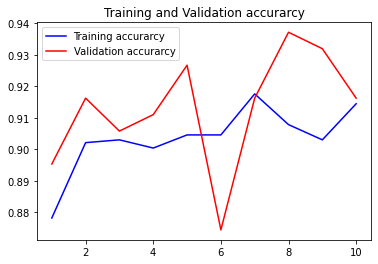

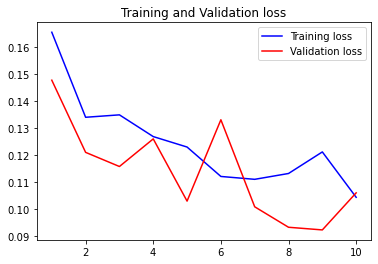

In [20]:
accuracy = m.history['accuracy']
val_accuracy = m.history['val_accuracy']
loss = m.history['loss']
val_loss = m.history['val_loss']
epochs = range(1, len(accuracy) + 1)

#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## Checking accuracy of trained model

In [22]:
print("Calculating Model Accuracy....")
accuracy_score = model.evaluate(x_test,y_test)
print(f"Accuracy: {accuracy_score[1]*100}")

Calculating Model Accuracy....
6/6 [==============================] - 1s 227ms/step - loss: 0.1060 - accuracy: 0.9162
Accuracy: 91.62303805351257


## Saving the trained model using pickle (for further implementation we will just need to load model and not train again)

In [23]:
print("Saving Trained Model...")
model.save('CornAnalysis.h5')
print('Model Saved Successfully...')

Saving Trained Model...
Model Saved Successfully...


## Function for calculating severity

In [1]:
def calSeverityCommonRust(img_path):
    img_1 = cv2.imread(img_path)
    img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 50])
    upper = np.array([110, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(hsv, hsv, mask = mask)
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for i in contours:
        cnt = cv2.contourArea(i)
        if cnt > 1000:  
            cv2.drawContours(img1, [i], 0, (179,179,179), -1)
    gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    print("Area of plant is ", area)
    
    
    gray = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    print(gray.dtype)
    blue_channel = img_1[:,:,0]
    background = (blue_channel <= 115)
    infected = (blue_channel > 115)
    number_of_infected_area = np.sum(infected == True)
    print("Infected Area Is : ", number_of_infected_area)
    severity = (number_of_infected_area / area) * 100
    print(severity, "% is infected")
    plt.imshow(img_1)
    
    if(severity > 0 and severity <= 30):
        print("Stage 1")
    if(severity >= 31 and severity <= 60):
        print("Stage 2")
    else:
        print("Stage 3")

In [2]:
def calSeverityGeayLeaf(img_path):
    img_1 = cv2.imread(img_path)
    img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 50])
    upper = np.array([110, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(hsv, hsv, mask = mask)
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for i in contours:
        cnt = cv2.contourArea(i)
        if cnt > 1000:  
            cv2.drawContours(img1, [i], 0, (179,179,179), -1)
    gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    print("Area of plant is ", area)
    
    
    gray = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    print(gray.dtype)
    blue_channel = img_1[:,:,0]
    background = (blue_channel <= 105)
    infected = (blue_channel > 105)
    number_of_infected_area = np.sum(infected == True)
    print("Infected Area Is : ", number_of_infected_area)
    severity = (number_of_infected_area / area) * 100
    print(severity, "% is infected")
    plt.imshow(img_1)
    if(severity > 0 and severity <= 30):
        print("Stage 1")
    if(severity >= 31 and severity <= 60):
        print("Stage 2")
    else:
        print("Stage 3")

In [3]:
def calSeverityNorthernLeaf(img_path):
    img_1 = cv2.imread(img_path)
    img1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 50])
    upper = np.array([110, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(hsv, hsv, mask = mask)
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for i in contours:
        cnt = cv2.contourArea(i)
        if cnt > 1000:  
            cv2.drawContours(img1, [i], 0, (179,179,179), -1)
    gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    print("Area of plant is ", area)
    
    
    gray = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    print(gray.dtype)
    blue_channel = img_1[:,:,0]
    background = (blue_channel <= 100)
    infected = (blue_channel > 100)
    number_of_infected_area = np.sum(infected == True)
    print("Infected Area Is : ", number_of_infected_area)
    severity = (number_of_infected_area / area) * 100
    print(severity, "% is infected")
    plt.imshow(img_1)
    if(severity > 0 and severity <= 30):
        print("Stage 1")
    if(severity >= 31 and severity <= 60):
        print("Stage 2")
    else:
        print("Stage 3")

## Testing images

In [6]:
imgPath = 'CornTestSet/CommonRust/RS_Rust 1630.JPG'
test_img = cv2.imread(imgPath)
plt.imshow(test_img)
test_img = test_img / 255
test_img = np.expand_dims(test_img, axis=0)
pr=m.predict(test_img)
print(pr,'\n')
output = label_binarizer.inverse_transform(pr)
print("Selected Image Is Predicted As " ,output)
if output != 'Healthy':
    if output == 'CommonRust':
        calSeverityCommonRust(imgPath)
    if output == 'GrayLeafSpot':
        calSeverityGeayLeaf(imgPath)
    if output == 'NorthernLeafBlight':
         calSeverityNorthernLeaf(imgPath)